In [1]:
import numpy as np
from scipy import linalg
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from IPython.display import clear_output
plt.rcParams['text.usetex'] = True


In [2]:
class statevector(np.ndarray): #extends the np.ndarray class to add functionalities like normalize, evolve under hamiltonian and also obtain density matrix
    def __new__(cls, input_array):
        obj = np.asarray(input_array, dtype=np.complex64).view(cls)
        return obj

    def H(self):
        return self.conj().T
    
    def get_norm(self):
        normVal = self.H()@self
        try:
            return normVal[0][0].real
        except:
            return normVal.real
    
    def normalize(self):
        if self.get_norm() != 0:
            self[:] = self/(self.get_norm()**0.5)
        return self
    
    def evolve(self, Hamiltonian, time:float, method:str='exact', dt:float=0):
        if method not in ['exact', 'trotter']:
            raise AttributeError(f"The specified method '{method}' does not exist.")
        
        if method == 'exact':
            evolvedstate = linalg.expm(-1j*Hamiltonian*time)@self
        else:
            size, __ = Hamiltonian.shape
            trotter_term = (operator(np.identity(size)) - 1j*Hamiltonian*dt)
            N = int(time/dt)
            evolvedstate = self
            for __ in range(N):
                evolvedstate = trotter_term@evolvedstate
            evolvedstate.view(statevector).normalize()
        
        self[:] = evolvedstate
        return self
    
    def get_rho(self):
        state = np.copy(self).view(statevector)
        state.normalize()
        rho = state@state.H()
        return rho.view(operator)
    
    
    def to_mathematica(self):
        string = '{'
        for row in self:
            string += '{'
            for element in row:
                string += str(element).replace('j', 'I') + ', '
            string = string[:-2] + '}, '
        string = string[:-2] + '}'
        return string


class operator(np.ndarray): #extends the np.ndarray class to add functionalities like expectation value of the operator for a given statevector
    def __new__(cls, input_array):
        obj = np.asarray(input_array, dtype=np.complex64).view(cls)
        return obj

    def H(self):
        return self.conj().T
    
    def expectation_value(self, state:statevector):
        state.normalize()
        exp_val =  state.H()@self@state
        try:
            return exp_val[0][0].real
        except:
            return exp_val.real
        
    
    def to_mathematica(self):
        string = '{'
        for row in self:
            string += '{'
            for element in row:
                string += str(element).replace('j', 'I') + ', '
            string = string[:-2] + '}, '
        string = string[:-2] + '}'
        return string

def natural_range(*args): #used to prevent confusions in coversion from natural index used in Hamiltonian and other Operators to python index
    '''
    natural_range(start, end) yields (i_p, i_n) where i_p is the programming index starting from start-1 to end-1 and i_n is the natural index starting from start to end. 
    'start' will default to 1 if natural_range is called with single arg.
    '''
    try:
        start = args[-2] - 1
    except:
        start = 0
    
    end = args[-1]
    
    for i in range(start, end):
        yield (i, i+1)


In [3]:
# basic defs
sx = operator([[0, 1],[1, 0]])
sy = operator([[0, -1j],[1j, 0]])
sz = operator([[1, 0],[0, -1]])
sp = (sx + 1j*sy)/2
sm = (sx - 1j*sy)/2
id_2 = operator(np.eye(2))

def Rx(theta:float) -> operator:
    return operator(linalg.expm(1j*theta*sx/2))
def Ry(theta:float) -> operator:
    return operator(linalg.expm(1j*theta*sy/2))
def Rz(theta:float) -> operator:
    return operator(linalg.expm(1j*theta*sz/2))


In [4]:
def get_pauli(
        N:int,
        ) -> tuple[list[operator]]:
    sigma_p = []
    sigma_m = []
    sigma_z = []

    sp_listform = [[sp if k==l else id_2 for k in range(N)] for l in range(N)]
    sm_listform = [[sm if k==l else id_2 for k in range(N)] for l in range(N)]
    sz_listform = [[sz if k==l else id_2 for k in range(N)] for l in range(N)]

    for i in range(N):
        temp = sp_listform[i][0]
        for pauli in sp_listform[i][1:]:
            temp = np.kron(temp, pauli)
        sigma_p.append(temp)

        temp = sm_listform[i][0]
        for pauli in sm_listform[i][1:]:
            temp = np.kron(temp, pauli)
        sigma_m.append(temp)

        temp = sz_listform[i][0]
        for pauli in sz_listform[i][1:]:
            temp = np.kron(temp, pauli)
        sigma_z.append(temp)

    id_N = operator(np.eye(2**N))

    return sigma_p, sigma_m, sigma_z, id_N

In [5]:
def get_hamiltonian(
        N:int, 
        coeffs: tuple[float]
        )->operator:
    '''
    takes N: numer of lattice sites and coeffs: (M, J, W) and returns the Hamiltonian for the system
    '''
    (sigma_p, sigma_m, sigma_z, id_N) = get_pauli(N)
    (M, J, W) = coeffs

    # the natural_range method returns the tuple (python index, natural index), which I have denoted by adding _p and _n to the indices

    # H_Z

    hamiltonian_z1 = operator(np.zeros_like(id_N))

    for (n_p, n_n) in natural_range(1, N):
        hamiltonian_z1 += (-1)**n_n*sigma_z[n_p]
    hamiltonian_z1 *= (M/(2*W))

    hamiltonian_z2 = operator(np.zeros_like(id_N))
    
    for (n_p, n_n) in natural_range(1, N-1):
        coeff = 1 - (-1)**n_n
        if coeff!=0:
            term = operator(np.zeros_like(id_N))
            for (l_p, l_n) in natural_range(1, n_n):
                term += sigma_z[l_p]
            hamiltonian_z2 += coeff*term

    hamiltonian_z2 *= (-J)/(4*W)

    hamiltonian_z = hamiltonian_z1 + hamiltonian_z2

    # H_{\pm}

    hamiltonian_pm = operator(np.zeros_like(id_N))

    for (n_p, n_n) in natural_range(1, N-1):
        term = sigma_p[n_p]@sigma_m[n_p + 1]
        hamiltonian_pm += term + term.H()
    
    # H_{ZZ}
    hamiltonian_zz = operator(np.zeros_like(id_N))

    for (n_p, n_n) in natural_range(1, N-2):
        for (l_p, l_n) in natural_range(n_n+1, N-1):
            hamiltonian_zz += (N - l_n)*sigma_z[n_p]@sigma_z[l_p]
    hamiltonian_zz *=  (J/(2*W))

    hamiltonian = hamiltonian_z + hamiltonian_pm + hamiltonian_zz

    return hamiltonian

In [6]:
def get_driving_hamiltonian(N:int):
    sigma_z_list = [[sx if i==j else id_2 for i in range(N)] for j in range(N)]
    hamiltonian = operator(np.zeros((2**N, 2**N)))

    for i in range(N):
        temp = sigma_z_list[i][0]
        for sigma in sigma_z_list[i][1:]:
            temp = np.kron(temp, sigma)
        hamiltonian += temp

    return operator(hamiltonian)
    

In [7]:
def get_particle_density(N:int) -> operator:
    __, __, sigma_z, id_N = get_pauli(N)

    particle_density = operator(np.zeros_like(id_N))

    for (n_p, n_n) in natural_range(1, N):
        particle_density += ((-1)**n_n)*sigma_z[n_p] + id_N

    particle_density /= (2*N)

    return particle_density

In [8]:
def get_order_parameter(N:int) -> operator:
    __, __, sigma_z, id_N = get_pauli(N)

    order_parameter = operator(np.zeros_like(id_N))

    for (i_p, i_n) in natural_range(1, N):
        for (j_p, j_n) in natural_range(i_n+1, N):
            order_parameter += ( ((-1)**i_n)*sigma_z[i_p] + id_N ) @ ( ((-1)**j_n)*sigma_z[j_p] + id_N ) 

    order_parameter /= (2*N*(N-1))

    return order_parameter

In [9]:
def get_init_state(N:int):
    e,v = np.linalg.eigh(get_driving_hamiltonian(N))
    min_e = np.min(e)
    id = np.where(e == min_e)[0][0]
    return statevector(v[:,id]).T

In [10]:
def half_chain_entanglement_entropy(state:statevector):
    rho = state.get_rho()
    N, _ = rho.shape
    N = np.log2(N)
    if N%2!=0:
        raise ValueError("Number of lattice sites should be even")
    half = 2**int(N/2)

    id_half = np.eye(half)

    rho_A = operator(np.zeros_like(id_half))

    for i in range(half):
        basis = statevector([1 if j==i else 0 for j in range(half)])
        left_mat = np.kron(basis, id_half)
        rho_A += left_mat @ rho @ left_mat.T

    entropy = -np.trace(rho_A @ linalg.logm(rho_A))

    return entropy.real

In [11]:
def adiabatic_evolution(N, coeffs, num_steps=10000):
    state = get_init_state(N)
    schwinger_hamiltonian = get_hamiltonian(N, coeffs)
    driving_hamiltonian = get_driving_hamiltonian(N)
    
    for step in tqdm(range(num_steps)):
        s = step / (num_steps - 1)
        
        H = (1 - s)*driving_hamiltonian + s*schwinger_hamiltonian
        
        state = state.evolve(H, 1)
        state = state.normalize()

    energy = H.expectation_value(state)
    
    return state, energy

In [13]:
num_sites = [4,6]
learning_rate = 1e-2
masses = [-5, -2, -1.5, -1, -0.6, -0.2, 0.2, 0.6, 1, 1.5, 2, 5]
num_steps = 50000
energies = []
states = []
for N in num_sites:
    states.append([])
    energies.append([])
    for m in masses:
        print(f"N = {N}, m = {m}")
        coeffs = (m, 1, 1)
        state, energy = adiabatic_evolution(N, coeffs, num_steps)
        states[-1].append(state)
        energies[-1].append(energy)
        clear_output()


In [14]:
def exact_diagonalisation(hamiltonian):
    e,v = np.linalg.eigh(hamiltonian)
    min_e = np.min(e)
    id = np.where(e == min_e)[0][0]
    return e[id], v[:,id]

In [15]:
states_e = []
energies_e = []
masses_e = np.linspace(-5, 5, 50)

for N in num_sites:
    states_e.append([])
    energies_e.append([])
    for m in masses_e:
        coeffs = (m, 1, 1)
        hamiltonian = get_hamiltonian(N, coeffs)
        energy, state = exact_diagonalisation(hamiltonian)
        states_e[-1].append(state)
        energies_e[-1].append(energy)

In [16]:
particle_densities = []
for i in range(len(num_sites)):
    particle_density_op = get_particle_density(num_sites[i])
    ground_states = states[i]
    particle_densities.append([particle_density_op.expectation_value(statevector(state)) for state in ground_states])

In [17]:
particle_densities_e = []
for i in range(len(num_sites)):
    particle_density_op = get_particle_density(num_sites[i])
    ground_states_e = states_e[i]
    particle_densities_e.append([particle_density_op.expectation_value(statevector(state)) for state in ground_states_e])

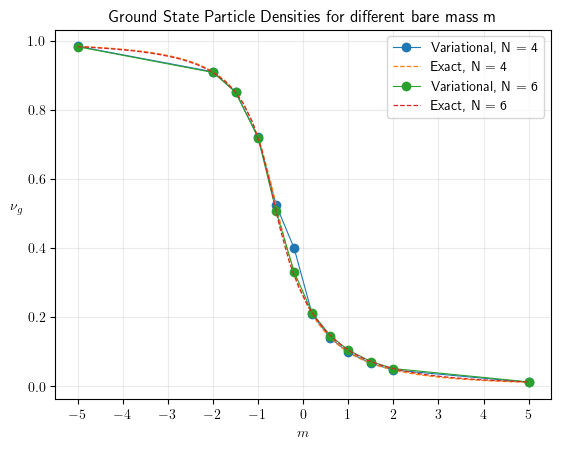

In [18]:
fig, ax = plt.subplots()
for i in range(len(num_sites)):
    ax.plot(masses, particle_densities[i], '.-', linewidth=0.8, markersize=12, label=f'Variational, N = {num_sites[i]}')
    ax.plot(masses_e, particle_densities_e[i], '--', linewidth=0.9, label=f'Exact, N = {num_sites[i]}')
ax.set_xticks(np.linspace(-5, 5, 11))
ax.set_xlabel(r"$m$")
ax.set_ylabel(r"$\nu_g$")
ax.yaxis.label.set(rotation='horizontal', ha='right')
ax.set_title("Ground State Particle Densities for different bare mass m")
ax.legend(loc='best')

plt.grid(True, alpha=0.25)

In [19]:
order_parameters = []
for i in range(len(num_sites)):
    order_parameter_op = get_order_parameter(num_sites[i])
    ground_states = states[i]
    order_parameters.append([order_parameter_op.expectation_value(statevector(state)) for state in ground_states])

In [20]:
order_parameters_e = []
for i in range(len(num_sites)):
    order_parameter_op = get_order_parameter(num_sites[i])
    ground_states = states_e[i]
    order_parameters_e.append([order_parameter_op.expectation_value(statevector(state)) for state in ground_states])

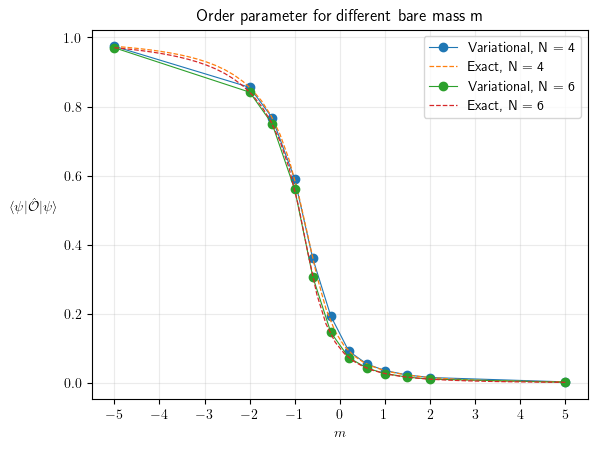

In [21]:
fig, ax = plt.subplots()
for i in range(len(num_sites)):
    ax.plot(masses, order_parameters[i], '.-', linewidth=0.8, markersize=12, label=f'Variational, N = {num_sites[i]}')
    ax.plot(masses_e, order_parameters_e[i], '--', linewidth=0.9, markersize=12, label=f'Exact, N = {num_sites[i]}')
ax.set_xticks(np.linspace(-5, 5, 11))
ax.set_xlabel("$m$")
ax.set_ylabel(r"$\langle \psi | \hat{\mathcal{O}} | \psi \rangle$")
ax.yaxis.label.set(rotation='horizontal', ha='right')
ax.set_title("Order parameter for different bare mass m")
ax.legend(loc='best')

plt.grid(True, alpha=0.25)

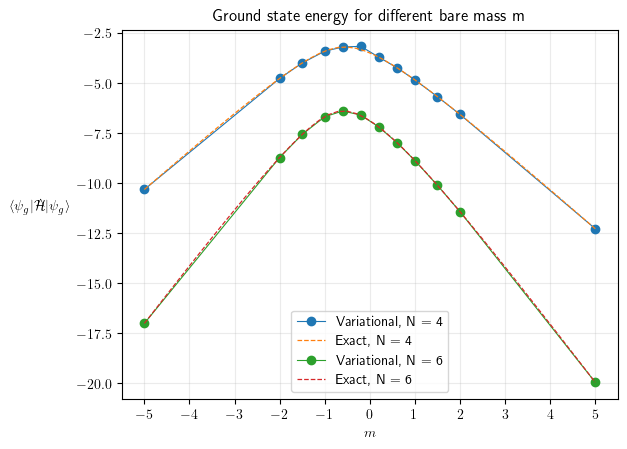

In [22]:
fig, ax = plt.subplots()
for i in range(len(num_sites)):
    ax.plot(masses, energies[i], '.-', linewidth=0.8, markersize=12, label=f'Variational, N = {num_sites[i]}')
    ax.plot(masses_e, energies_e[i], '--', linewidth=0.9, markersize=12, label=f' Exact, N = {num_sites[i]}')
ax.set_xticks(np.linspace(-5, 5, 11))
ax.set_xlabel(r"$m$")
ax.set_ylabel(r"$\langle \psi_g | \mathcal{\hat{H}} | \psi_g \rangle$")
ax.yaxis.label.set(rotation='horizontal', ha='right')
ax.set_title("Ground state energy for different bare mass m")
ax.legend(loc='best')

plt.grid(True, alpha=0.25)

In [ ]:
entanglement_e = []
for i in range(len(num_sites)):
    ground_states_e = states_e[i]
    entanglement_e.append([half_chain_entanglement_entropy(statevector(np.reshape(state, (state.size, 1)))) for state in ground_states_e])

In [ ]:
entanglement = []
for i in range(len(num_sites)):
    ground_states = states[i]
    entanglement.append([half_chain_entanglement_entropy(statevector(np.reshape(state, (state.size, 1)))) for state in ground_states])

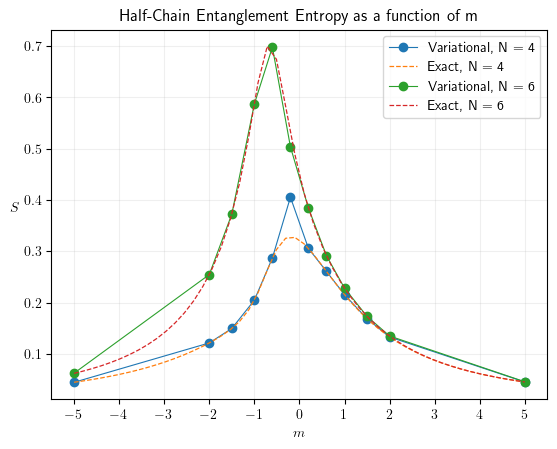

In [25]:
fig, ax = plt.subplots()
for i in range(len(num_sites)):
    ax.plot(masses, entanglement[i], '.-', linewidth=0.8, markersize=12, label=f'Variational, N = {num_sites[i]}')
    ax.plot(masses_e, entanglement_e[i], '--', linewidth=0.9, markersize=12, label=f' Exact, N = {num_sites[i]}')
ax.set_xticks(np.linspace(-5, 5, 11))
ax.set_xlabel(r"$m$")
ax.set_ylabel(r"$S$")
ax.yaxis.label.set(rotation='horizontal', ha='right')
ax.set_title("Half-Chain Entanglement Entropy as a function of m")
ax.legend(loc='best')

plt.grid(True, alpha=0.2)

In [26]:
states_c = [] #states and energies to compare the variational method and exact diagonalisation
energies_c = []

for N in num_sites:
    states_c.append([])
    energies_c.append([])
    for m in masses:
        coeffs = (m, 1, 1)
        hamiltonian = get_hamiltonian(N, coeffs)
        energy, state = exact_diagonalisation(hamiltonian)
        states_c[-1].append(state)
        energies_c[-1].append(energy)

In [27]:
overlaps = []
for i in range(len(num_sites)):
    overlaps.append([])
    for exact_state, var_state in zip(states_c[i], states[i]):
        exact_state = statevector(exact_state)
        var_state = statevector(var_state)
        overlap = abs((var_state.H()@exact_state))
        overlaps[-1].append(overlap)

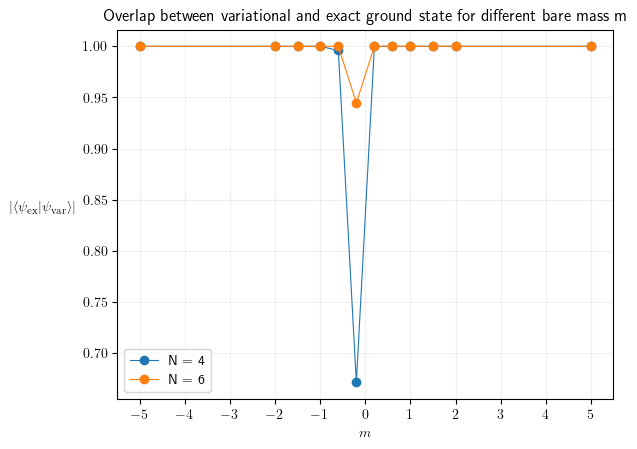

In [28]:
fig, ax = plt.subplots()
for i in range(len(num_sites)):
    ax.plot(masses, overlaps[i], '.-', linewidth=0.8, markersize=12, label=f'N = {num_sites[i]}')
ax.set_xticks(np.linspace(-5, 5, 11))
ax.set_xlabel(r"$m$")
ax.set_ylabel(r"$|\langle \psi_{\mathrm{ex}} | \psi_{\mathrm{var}} \rangle|$")
ax.yaxis.label.set(rotation='horizontal', ha='right')
ax.set_title("Overlap between variational and exact ground state for different bare mass m")
ax.legend(loc='best')

plt.grid(True, alpha=0.2)

In [29]:
perc_energy_diffs = []
for i in range(len(num_sites)):
    perc_energy_diffs.append([])
    for e_e, e_v in zip(energies_c[i], energies[i]):
        perc_energy_diffs[i].append(100*abs(e_e - e_v) / abs(e_e))

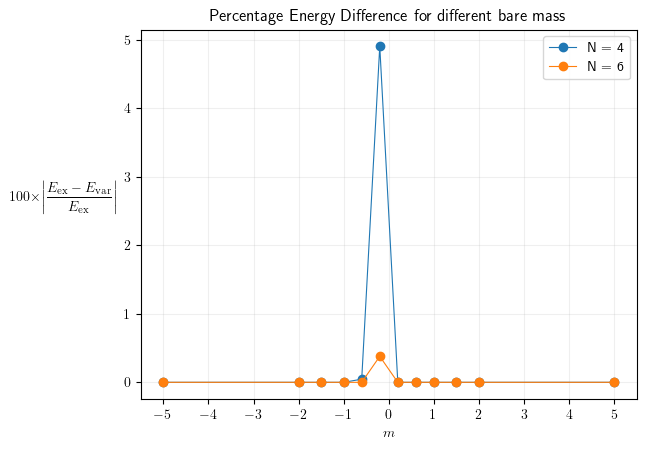

In [30]:
fig, ax = plt.subplots()
for i in range(len(num_sites)):
    ax.plot(masses, perc_energy_diffs[i], '.-', linewidth=0.8, markersize=12, label=f'N = {num_sites[i]}')
ax.set_xticks(np.linspace(-5, 5, 11))
ax.set_xlabel(r"$m$")
ax.set_ylabel(r"$100\times \biggr | \displaystyle \frac{E_{\mathrm{ex}} - E_{\mathrm{var}}}{E_{\mathrm{ex}}} \biggr |$")
ax.set_title("Percentage Energy Difference for different bare mass")
ax.yaxis.label.set(rotation='horizontal', ha='right')
ax.legend(loc='best')

plt.grid(True, alpha=0.2)